<center>
    <h1>Reconocimiento de patrones y aprendizaje automático</h1>
    <h1>Proyecto final: Predicción de clase en modelo de boids</h1>
    <h2>González Alvarado Raúl : 313245312</h2>
</center>

## Introducción

El modelo de boids (o de comportamiento de enjambre), es un modelo usado para describir el 
comportamiento de rebaño o enjambre que se presentan en colonias de animales, e incluso en 
cómo se comportan los humanos de manera colectiva en un entorno con interacciones.
Estos modelos se componen de una población de individuos o partículas, las cuales tienen 
un comportamiento individual, pero que en conjunto, presentan un comportamiento complejo 
gracias a las interacciones causadas por sus reglas individuales. 
Los autores de estos modelos usan la norma de la velocidad promedio de todos los individuos 
para determinar si la dinámica presentada por el sistema es ordenada o caótica;
o en otras palabras: si se presenta comportamiento de enjambre o no.

Este proyecto tiene como objetivo encontrar un modelo que se pueda determinar si dado una 
instantánea del sistema se puede determinar el comportamiento del mismo. 
Se presentan dos clases en el sistema: la de flock/group que es cuando los individuos se 
comportan como enjambre o cuando est ́an agrupados, y no flock cuando no se presenta 
comportamiento de enjambre ni de agrupamiento. 
También se quiere determinar si el modelo encontrado puede no depender de la velocidad de 
los individuos para hacer la clasificación correctamente.

## Dataset

Los datos utilizados fueron extraídos del sitio web de [Kaggle](https://www.kaggle.com/deepcontractor/swarm-behaviour-classification). 
Cada renglón es una población compuesta de 200 individuos de los cuales se tiene 
su posición $xm$, $ym$ con $m$ el número del individuo; su vector de velocidad $xVelm$,
$yVelm$; su vector de alineación $xAm$, $yAm$, su vector de separación $xSm$, $ySm$, 
su vector de cohesión $xCm$, $yCm$, la cantidad de vecinos en su radio de separación $mSn$ 
y la cantidad de vecinos en su radio de alineación/cohesión $nACm$; finalmente está 
la etiqueta _Swarm Behaviour_ que nos dice si la población está ordenada en flock/group 
con un 1; o si no lo está con un 0. 
Nos da un total de 2401 columnas por cada población, y son en total 23309 poblaciones.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Swarm_Behaviour.csv")

In [53]:
data.head()

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Swarm_Behaviour
0,562.05,-0.62,-10.70,-4.33,0.00,0.00,0.0,0.0,0.00,0.00,...,-15.15,0.00,0.00,0.00,0.00,0.00,0.0,28,0,0.0
1,175.66,-57.09,2.31,-2.67,0.00,0.00,0.0,0.0,0.00,0.00,...,-3.48,0.00,0.00,0.00,0.00,0.00,0.0,4,0,0.0
2,200.16,-320.07,4.01,-6.37,0.00,0.00,0.0,0.0,0.18,-0.26,...,-9.38,0.00,0.00,0.00,0.00,-0.11,-0.3,15,1,0.0
3,316.99,-906.84,0.85,9.17,-0.17,1.03,0.0,0.0,0.00,0.00,...,10.39,-0.26,1.01,0.00,0.00,0.00,0.0,16,0,0.0
4,1277.68,908.54,-2.02,8.23,-1.00,1.00,0.0,0.0,0.00,0.00,...,13.91,-1.00,0.00,3.21,15.67,0.00,0.0,12,0,0.0


## Exploración de datos

Para hacer la exploración de datos se verificaron los rangos de cada columna ya que algúnos
están en $-1400, 1400$, otros están en $-2,2$ y otros en $0, 175$ con lo cuál se tendrá
que hacer un escalamiento para los modelos que van a ser probados más adelante. 

El balanceo en las clases a predecir: la clase 0 (65.8 %) estaba un poco más cargada que 
la clase 1, con lo cuál también vamos a tener que lidiar con este desbalanceo más adelante.

In [56]:
seed = 1231
label_name = "Swarm_Behaviour"
attribs = ["", "Vel", "A", "S", "C", "nAC", "nS"]

In [57]:
describe = data.describe()
describe

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Swarm_Behaviour
count,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,...,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000,23309.000000
mean,104.413631,-73.481853,-0.697607,0.061480,-0.147964,0.152034,-1.055732,-0.731546,-0.034915,0.077123,...,0.086824,-0.126276,0.127497,-1.526260,-0.118891,-0.012388,0.085076,26.433995,2.130679,0.341242
std,843.200079,573.329374,6.427840,7.366739,0.376078,0.588582,26.388570,20.684183,0.559690,0.628478,...,7.683539,0.378830,0.570589,73.903764,7.002853,0.555143,0.614603,34.136098,7.431911,0.474136
min,-1414.140000,-1012.180000,-18.590000,-18.410000,-1.000000,-1.000000,-944.070000,-847.910000,-2.680000,-2.680000,...,-18.440000,-1.040000,-1.000000,-4079.230000,-370.240000,-2.680000,-2.680000,0.000000,0.000000,0.000000
25%,-542.020000,-611.220000,-5.360000,-5.680000,-0.230000,-0.010000,0.000000,0.000000,-0.040000,-0.020000,...,-5.600000,-0.190000,0.000000,0.000000,0.000000,-0.070000,0.000000,2.000000,0.000000,0.000000
50%,145.300000,-157.350000,-0.450000,-1.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000
75%,896.200000,425.700000,3.940000,7.260000,0.000000,0.940000,0.000000,0.000000,0.000000,0.020000,...,7.480000,0.000000,0.540000,0.000000,0.000000,0.000000,0.030000,35.000000,1.000000,1.000000
max,1406.080000,1015.800000,18.470000,18.570000,1.000000,1.040000,68.560000,234.740000,2.680000,2.680000,...,18.490000,1.000000,1.040000,255.990000,57.840000,2.680000,2.680000,142.000000,64.000000,1.000000


In [58]:
def attrib_names(attrib="", coords=["x","y"], coord=None):
    c = coords if coord == None else [coord]
    return [f"{coord}{attrib}{num}" for num in range(1, 201) for coord in c]

# Example:
# >>> attrib_names("Vel")
# ['xVel1',
# 'yVel1',
# 'xVel2',
# 'yVel2',
# 'xVel3',
# 'yVel3'
# ...

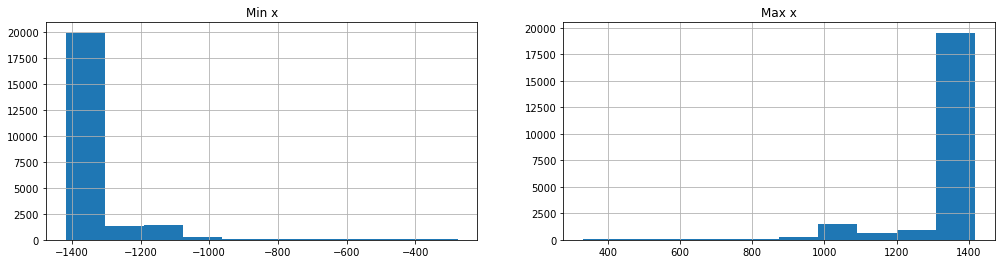

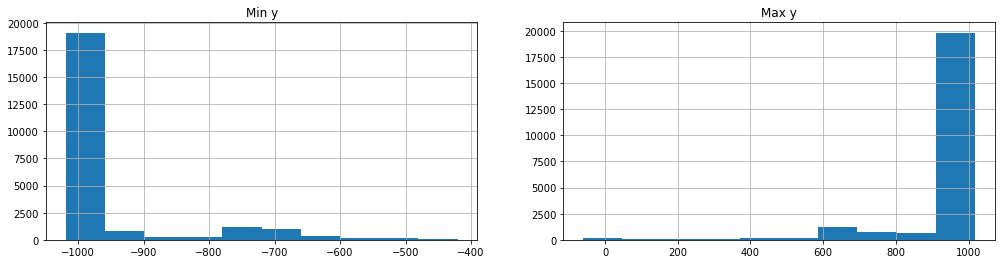

Vel


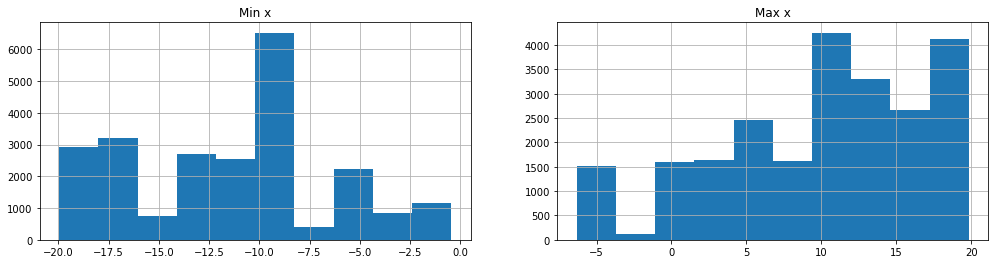

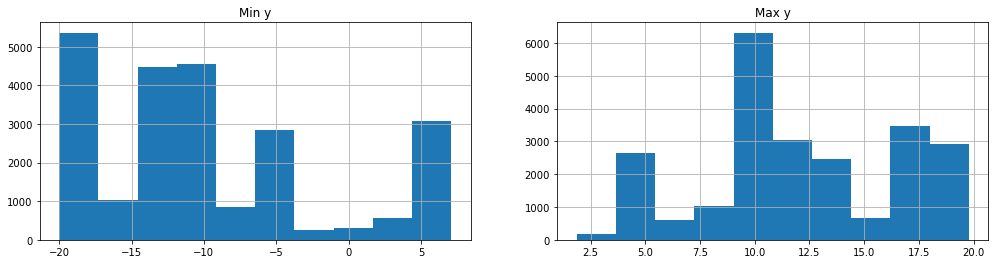

A


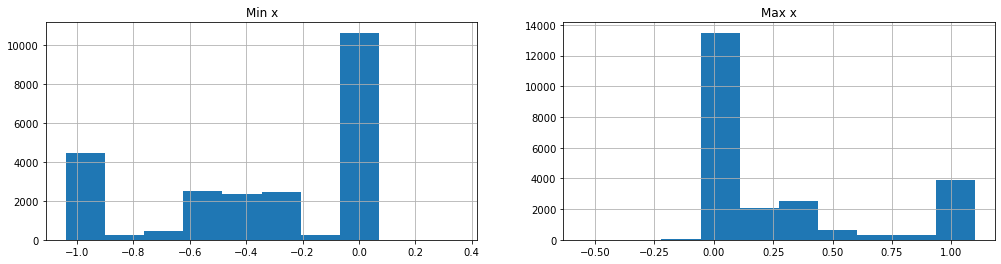

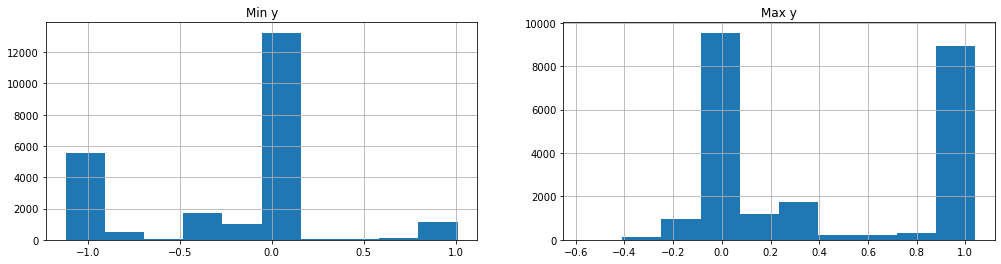

S


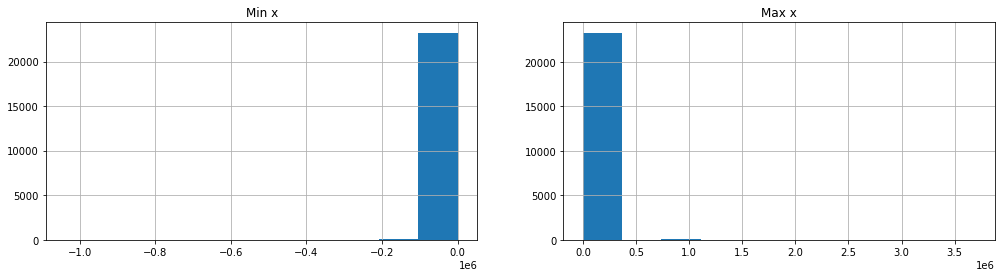

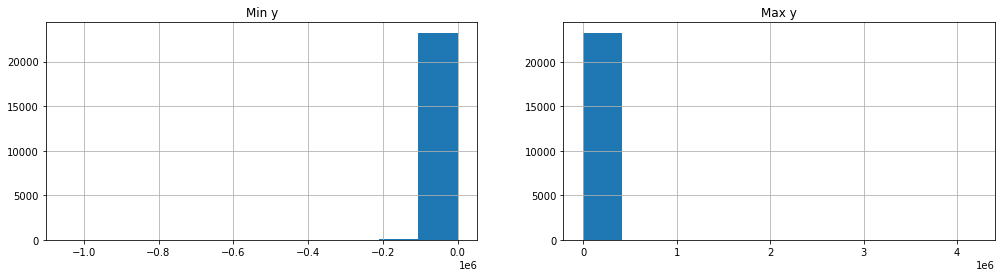

C


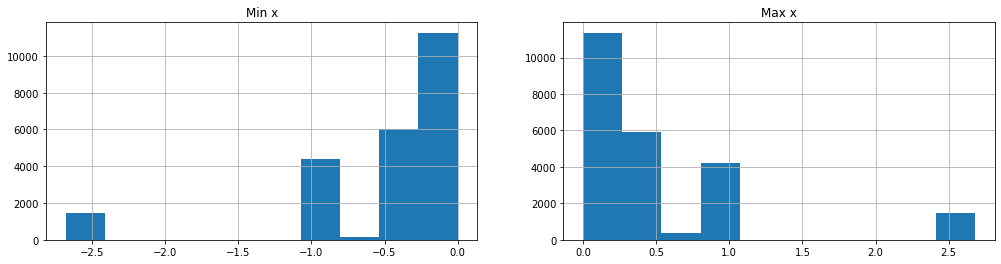

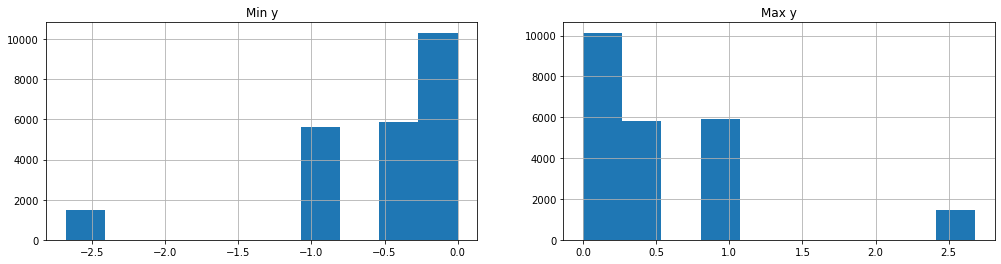

nAC


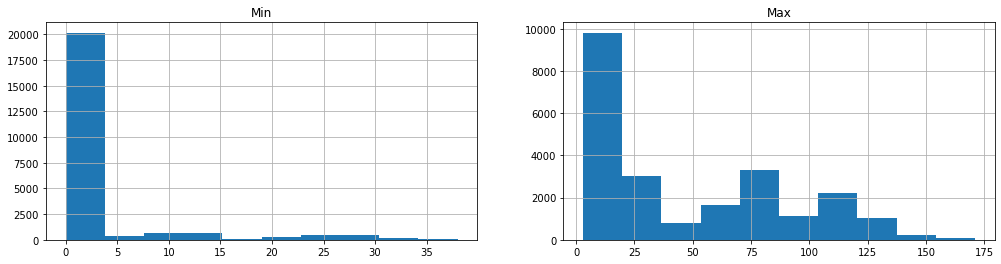

nS


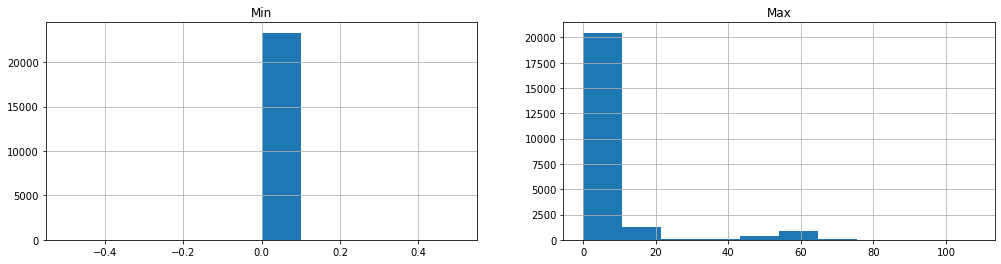

In [59]:
for attrib in attribs[:-2]:
    print(attrib)
    for c in ["x", "y"]:
        cols = attrib_names(attrib, coord=c)
        plt.figure(figsize=(17,4))
        plt.subplot(1,2,1)
        plt.title(f"Min {c}")
        data[cols].min(axis=1).hist()
        plt.subplot(1,2,2)
        plt.title(f"Max {c}")
        data[cols].max(axis=1).hist()
        plt.show()
for attrib in attribs[-2:]:
    print(attrib)
    cols = attrib_names(attrib, coord="")
    plt.figure(figsize=(17,4))
    plt.subplot(1,2,1)
    plt.title("Min")
    data[cols].min(axis=1).hist()
    plt.subplot(1,2,2)
    plt.title("Max")
    data[cols].max(axis=1).hist()
    plt.show()

In [7]:
def psi(population, N=200):
    speeds = list()
    total_velocity = np.array([0,0], dtype="float64")
    for i in range(1, N+1):
        vi = population[[f"xVel{i}", f"yVel{i}"]]
        total_velocity += vi.to_numpy()
        speed = np.linalg.norm(vi)
        speeds.append(speed)
    v0 = np.mean(speeds)
    psi = np.linalg.norm(total_velocity) / (v0 * N)
    return psi

In [8]:
def plot_population(row):
    X = row[attrib_names("", coord="x")]
    Y = row[attrib_names("", coord="y")]
    X_vel = row[attrib_names("Vel", coord="x")]
    Y_vel = row[attrib_names("Vel", coord="y")]
    X_a = row[attrib_names("A", coord="x")]
    Y_a = row[attrib_names("A", coord="y")]
    plt.scatter(X, Y, marker=".", c="r")
    plt.quiver(X, Y, X_vel, Y_vel, color="blue", width=0.003)
    plt.quiver(X, Y, X_a, Y_a, color="green", width=0.003)
    plt.xticks([])
    plt.yticks([])

In [10]:
flock = data[data[label_name] == 1]
no_flock = data[data[label_name] == 0]

Unas cuantas visualizaciónes de algunas poblaciones que están etiquetadas cómo flock.
Los puntos rojos son los individuos, la flecha azul es su vector velocidad y el
verde es su vector de alineación.

/opt/anaconda/lib/python3.8/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/anaconda/lib/python3.8/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


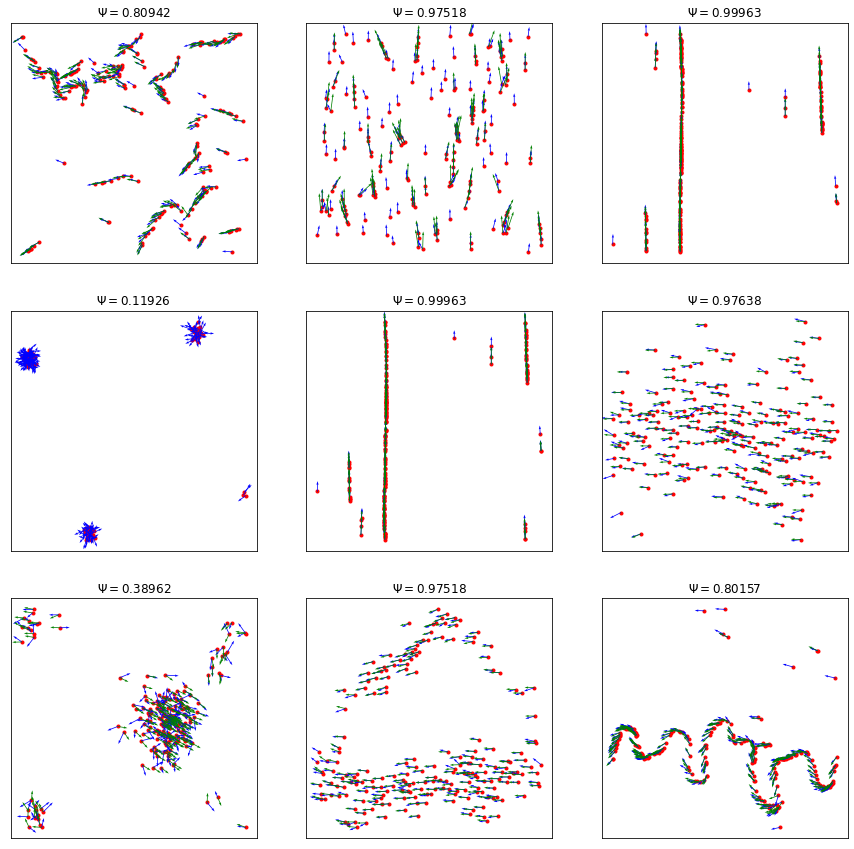

In [11]:
figures = 3
plt.figure(figsize=(15, figures*5))
num_samples = figures * 3
samples = flock.sample(num_samples)
for idx in range(num_samples):
    row = samples.iloc[idx]
    plt.subplot(figures, 3, idx+1)
    plot_population(row)
    plt.title(f"$\Psi = {round(psi(row), 5)}$")
plt.show()

## Preparación de los datos

Para lidiar con el desbalanceo vamos a hacer un sobre-muestreo, es decir
hacer un muestreo con reemplazo en la clase con menos ejemplares (en este
caso la clase 1) hasta que tengamos la misma cantidad de ejemplares que la
clase 0.

In [12]:
def show_balance(target):
    classes = target.unique()
    classes_count = target.value_counts() * 100
    classes_percentage = round(classes_count / len(target), 2)
    for idx in range(len(classes)):
        c = classes[idx]
        c_percentage = classes_percentage[idx]
        print(f"Class {c}: {c_percentage}%")
    target.hist()
    plt.show()

Class 0.0: 65.88%
Class 1.0: 34.12%


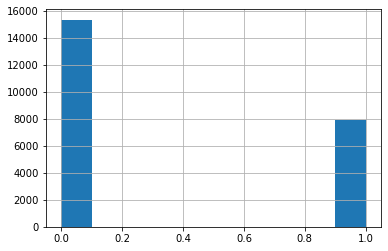

In [13]:
show_balance(data[label_name])

In [14]:
# Balanceo de datos
flock_aumented = flock.sample(len(no_flock), replace=True, random_state=seed)
balanced_data = pd.concat([no_flock, flock_aumented])

Class 0.0: 50.0%
Class 1.0: 50.0%


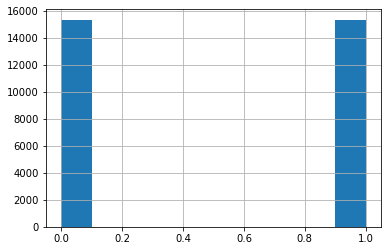

In [15]:
show_balance(balanced_data[label_name])

In [16]:
from sklearn.model_selection import train_test_split

def split_Xy(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    return X, y

Al ser un sistema descentralizado sabemos que nigúno de los individuos tiene más
importancia que los otros, entonces para reducir la cantidad de columnas tomé
la varianza de cada attributo dentro de una sola población.

In [17]:
var_data = balanced_data.iloc[:]
for attrib in attribs[:-2]:
    X = var_data[attrib_names(attrib, coord="x")]
    Y = var_data[attrib_names(attrib, coord="y")]
    var_data[f"x{attrib}"] = np.var(X, axis=1)
    var_data[f"y{attrib}"] = np.var(Y, axis=1)
for attrib in attribs[-2:]:
    X = var_data[attrib_names(attrib, coord="")]
    var_data[f"{attrib}"] = np.var(X, axis=1)

In [18]:
var_columns = [f"{coord}{attrib}" for attrib in attribs[:-2] for coord in ["x", "y"]]
var_columns = var_columns + attribs[-2:] + [label_name]
var_data[var_columns].groupby(label_name).mean()

,x,y,xVel,yVel,xA,yA,xS,yS,xC,yC,nAC,nS
Swarm_Behaviour,,,,,,,,,,,,
0.0,614466.506222,322819.083100,34.901407,36.569414,0.052841,0.047751,5.154456e+07,8.972312e+07,0.206914,0.202473,271.615360,12.607043
1.0,567822.225617,259760.928366,10.456487,11.811849,0.058480,0.087144,1.409334e+03,9.374594e+02,0.463229,0.496304,262.846778,24.458622


La división de los datos se hizo en entrenamiento 75% y prueba 25%, 
elegí tomar el 25% porque son 30mil datos (luego del sobremuestreo).

In [19]:
train_set, test_set = train_test_split(var_data[var_columns], test_size=0.25, random_state=seed)
X_train, y_train = split_Xy(train_set, label_name)
X_test, y_test = split_Xy(test_set, label_name)

Más adelante vamos a usar modelos que son sensibles a la escala de los datos,
con lo cuál aquí escalamos los datos normalizando en $0,1$, los estandarizamos
y también sacamos para el `y_train` su codificación en OneHot.

Nótese que no se hizo la estandarización sobre los mismos datos normalizados,
si no que tenemos 2 conjuntos diferentes: `X_train_mm` que está normalizado
y `X_train_std` que está estandarizado.

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_mm = mm_scaler.transform(X_train)

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)

y_train_one_hot = OneHotEncoder(sparse=False).fit_transform(y_train.to_numpy().reshape((-1,1)))

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, accuracy_score
    
def show_reports(y_real, y_pred):
    labels = ["Disperse", "Groupped"]
    print(classification_report(y_real, y_pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(y_real, y_pred, normalize="true")
    RocCurveDisplay.from_predictions(y_real, y_pred)

In [22]:
def predict_model(model, X):
    y_pred_score = model.predict(X)
    y_pred = np.argmax(np.round(y_pred_score), axis=1)
    return y_pred

## Modelos

Los modelso usados son:
- Regresión Logística
- Árbol de decisión
- Bosque aleatorio
- Máquina de soporte vectorial
- Perceptrón multicapa

Todos los modelos fueron entrenados con hiperparámetros por defecto
solo para determinar qué modelos tienen el mejor desempeño y seguir
ajustando los hiperparámetros para obtener un mejor modelo.

En el caso de el _MLP_ la arquitectura utilizada fue 2 capas ocultas
con 12 neuronas y la segunda con 6; ambas con activación `relu` y densas.
La capa de salida es `softmax` y solo tiene 2 neurones.

En el caso de el árbol de decisión y el bosque aleatorio se pasaron los
datos como tal, pero con la regresión logística y el perceptrón se
usaron los datos normalizados en $0,1$, para la svm se usaron los
datos estandarizados.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow import keras

2022-02-02 14:39:57.273436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-02 14:39:57.273466: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


              precision    recall  f1-score   support

    Disperse       0.95      0.88      0.91      3818
    Groupped       0.89      0.96      0.92      3860

    accuracy                           0.92      7678
   macro avg       0.92      0.92      0.92      7678
weighted avg       0.92      0.92      0.92      7678



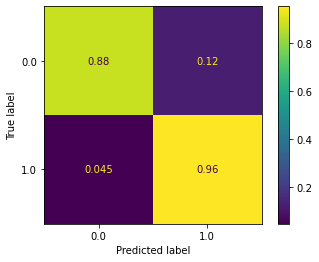

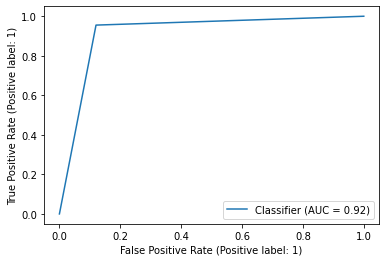

In [24]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)
show_reports(y_test, rf.predict(X_test))

              precision    recall  f1-score   support

    Disperse       0.96      0.87      0.91      3818
    Groupped       0.88      0.96      0.92      3860

    accuracy                           0.91      7678
   macro avg       0.92      0.91      0.91      7678
weighted avg       0.92      0.91      0.91      7678



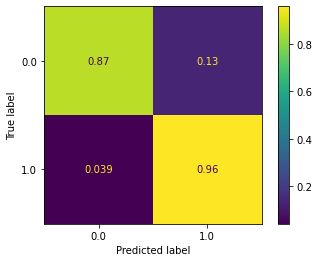

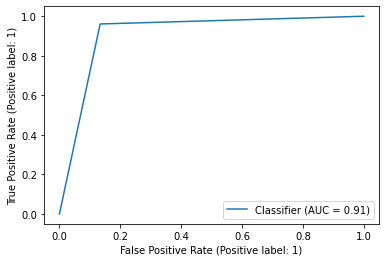

In [25]:
lr = LogisticRegression()
lr.fit(X_train_mm, y_train)
show_reports(y_test, lr.predict(mm_scaler.transform(X_test)))

              precision    recall  f1-score   support

    Disperse       0.92      0.90      0.91      3818
    Groupped       0.90      0.92      0.91      3860

    accuracy                           0.91      7678
   macro avg       0.91      0.91      0.91      7678
weighted avg       0.91      0.91      0.91      7678



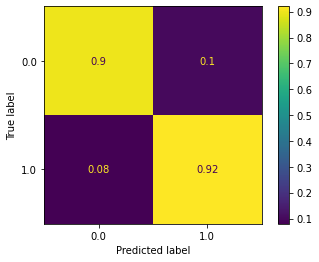

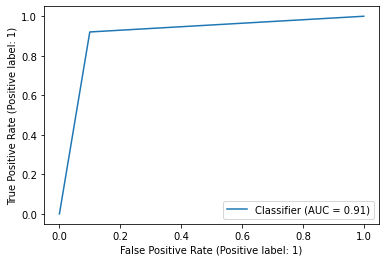

In [26]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, y_train)
show_reports(y_test, dt.predict(X_test))

              precision    recall  f1-score   support

    Disperse       1.00      0.85      0.92      3818
    Groupped       0.87      1.00      0.93      3860

    accuracy                           0.92      7678
   macro avg       0.94      0.92      0.92      7678
weighted avg       0.93      0.92      0.92      7678



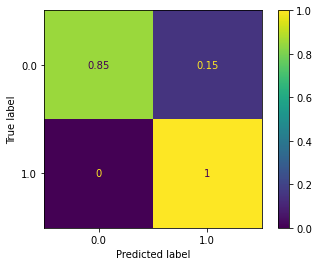

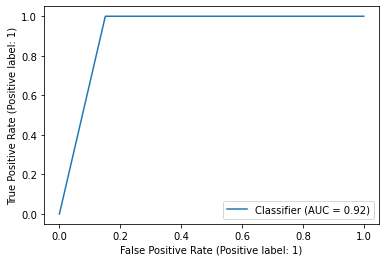

In [27]:
svc = SVC()
svc.fit(X_train_std, y_train)
show_reports(y_test, svc.predict(std_scaler.transform(X_test)))

In [28]:
mlp = keras.models.Sequential()
mlp.add(keras.layers.Dense(12, activation="relu", input_shape=(X_train_mm.shape[1],)))
mlp.add(keras.layers.Dense(6, activation="relu"))
mlp.add(keras.layers.Dense(2, activation="softmax"))
mlp.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
 dense_2 (Dense)             (None, 2)                 14        
                                                                 
Total params: 248
Trainable params: 248
Non-trainable params: 0
_________________________________________________________________


2022-02-02 14:40:16.568299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-02 14:40:16.568342: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-02 14:40:16.568368: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad-endevouros): /proc/driver/nvidia/version does not exist
2022-02-02 14:40:16.568625: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
mlp.fit(X_train_mm, y_train_one_hot, epochs=3, validation_split=0.1)

Epoch 1/3
648/648 [==============================] - 2s 2ms/step - loss: 0.3608 - accuracy: 0.8861 - val_loss: 0.1956 - val_accuracy: 0.9119
Epoch 2/3
648/648 [==============================] - 1s 2ms/step - loss: 0.1762 - accuracy: 0.9209 - val_loss: 0.1740 - val_accuracy: 0.9149
Epoch 3/3
648/648 [==============================] - 1s 2ms/step - loss: 0.1633 - accuracy: 0.9206 - val_loss: 0.1671 - val_accuracy: 0.9119


              precision    recall  f1-score   support

    Disperse       0.95      0.87      0.91      3818
    Groupped       0.88      0.95      0.92      3860

    accuracy                           0.91      7678
   macro avg       0.91      0.91      0.91      7678
weighted avg       0.91      0.91      0.91      7678



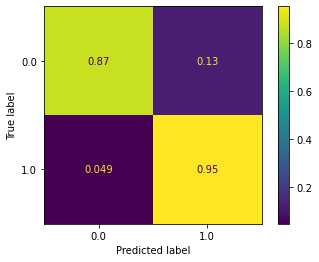

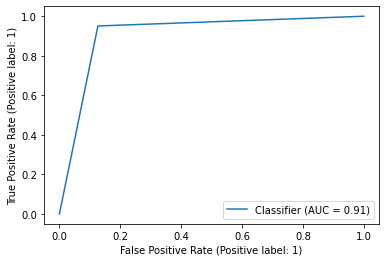

In [30]:
show_reports(y_test, predict_model(mlp, mm_scaler.transform(X_test)))

## Afinamiento de hiper-parámetros

Todos los modelos tuvieron resultados similares así que se optó
por elegir a el árbol de decisión porque tuvo resultados muy balanceados;
y a la svm porque logró un 1 en recall para la clase flock.

El tuneo de hiperparámetros se hizo con un 5-fold cross validation y 
con ayuda de la función `GridSearchCV`. En el caso del árbol se buscó
regularizar el tamaño del árbol, la cantidad de atributos que tomaba en
cuenta y el criterio para la constrocción del árbol: `gini` o `entropy`.
En el caso de la svm se limitó el número de iteraciones a 1000 y se
probó con kernel polinomial y rbf.

In [31]:
from sklearn.model_selection import GridSearchCV

### Decision Tree tunning

In [32]:
dt_gs = DecisionTreeClassifier(random_state=seed)
dt_param_grid = [
    {"criterion": ["gini", "entropy"], "max_depth": [2, 4, 8, 16, 32]},
    {"max_depth": [2, 4, 8, 16, 32], "max_features": [1.0, "sqrt", "log2"]},
    {"min_samples_split": [2, 20, 40, 60, 100], "max_leaf_nodes": [2, 4, 8, 16, 32, 64]},
    {"criterion": ["gini", "entropy"], "max_leaf_nodes": [2, 4, 8, 16, 32, 64], "min_samples_split": [2, 20, 40, 60, 100]}
]

In [33]:
dt_grid_search = GridSearchCV(dt_gs, dt_param_grid, scoring="accuracy", cv=5, return_train_score=True)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1231),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 4, 8, 16, 32]},
                         {'max_depth': [2, 4, 8, 16, 32],
                          'max_features': [1.0, 'sqrt', 'log2']},
                         {'max_leaf_nodes': [2, 4, 8, 16, 32, 64],
                          'min_samples_split': [2, 20, 40, 60, 100]},
                         {'criterion': ['gini', 'entropy'],
                          'max_leaf_nodes': [2, 4, 8, 16, 32, 64],
                          'min_samples_split': [2, 20, 40, 60, 100]}],
             return_train_score=True, scoring='accuracy')

In [34]:
dt_results = dt_grid_search.cv_results_
sorted_dt_results = sorted(zip(dt_results["mean_test_score"], dt_results["params"]), key=lambda x: x[0], reverse=True)
for score, param in sorted_dt_results[:10]:
    print(score, param)

0.9264500178653545 {'criterion': 'entropy', 'max_leaf_nodes': 8, 'min_samples_split': 2}
0.9264500178653545 {'criterion': 'entropy', 'max_leaf_nodes': 8, 'min_samples_split': 20}
0.9264500178653545 {'criterion': 'entropy', 'max_leaf_nodes': 8, 'min_samples_split': 40}
0.9264500178653545 {'criterion': 'entropy', 'max_leaf_nodes': 8, 'min_samples_split': 60}
0.9264500178653545 {'criterion': 'entropy', 'max_leaf_nodes': 8, 'min_samples_split': 100}
0.9261461418987004 {'max_leaf_nodes': 16, 'min_samples_split': 2}
0.9261461418987004 {'criterion': 'gini', 'max_leaf_nodes': 16, 'min_samples_split': 2}
0.9261460759227143 {'criterion': 'entropy', 'max_depth': 4}
0.9260158770267941 {'max_leaf_nodes': 16, 'min_samples_split': 20}
0.9260158770267941 {'max_leaf_nodes': 16, 'min_samples_split': 40}


              precision    recall  f1-score   support

    Disperse       1.00      0.85      0.92      3818
    Groupped       0.87      1.00      0.93      3860

    accuracy                           0.92      7678
   macro avg       0.93      0.92      0.92      7678
weighted avg       0.93      0.92      0.92      7678



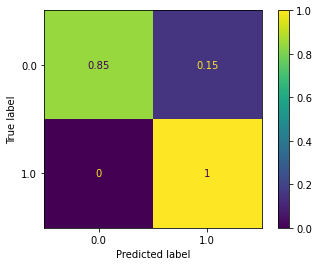

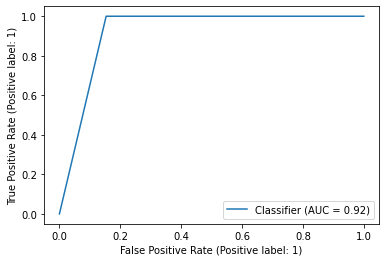

In [35]:
best_dt = dt_grid_search.best_estimator_
show_reports(y_test, best_dt.predict(X_test))

### SVC tunning

In [36]:
svc_gs = SVC(max_iter=1000)
svc_param_grid = [
    {"kernel": ["poly"], "degree": [3, 6, 12, 24, 48]},
    {"kernel": ["rbf"], "gamma": [0.1, 5, 10], "C": [0.001, 1000]}
]

In [37]:
svc_grid_search = GridSearchCV(svc_gs, svc_param_grid, scoring="accuracy", cv=5, return_train_score=True)
svc_grid_search.fit(std_scaler.transform(X_train), y_train)

/opt/anaconda/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).

GridSearchCV(cv=5, estimator=SVC(max_iter=1000),
             param_grid=[{'degree': [3, 6, 12, 24, 48], 'kernel': ['poly']},
                         {'C': [0.001, 1000], 'gamma': [0.1, 5, 10],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='accuracy')

In [38]:
svc_results = svc_grid_search.cv_results_
sorted_svc_results = sorted(zip(svc_results["mean_test_score"], svc_results["params"]), key=lambda x: x[0], reverse=True)
for score, param in sorted_svc_results[:10]:
    print(score, param)

0.8612755080834251 {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.8209452926181072 {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.592696835348727 {'C': 0.001, 'gamma': 5, 'kernel': 'rbf'}
0.5791094486000414 {'C': 1000, 'gamma': 5, 'kernel': 'rbf'}
0.5491495554019676 {'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}
0.5408985514595255 {'C': 1000, 'gamma': 10, 'kernel': 'rbf'}
0.5037776812852801 {'degree': 48, 'kernel': 'poly'}
0.4997395739327371 {'degree': 24, 'kernel': 'poly'}
0.4989149212326841 {'degree': 3, 'kernel': 'poly'}
0.497568860314794 {'degree': 6, 'kernel': 'poly'}


              precision    recall  f1-score   support

    Disperse       0.87      0.90      0.89      3818
    Groupped       0.90      0.87      0.89      3860

    accuracy                           0.89      7678
   macro avg       0.89      0.89      0.89      7678
weighted avg       0.89      0.89      0.89      7678



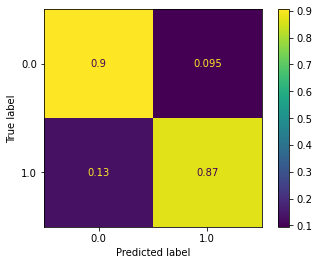

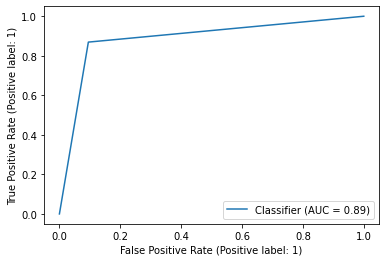

In [39]:
best_svc = svc_grid_search.best_estimator_
show_reports(y_test, best_svc.predict(std_scaler.transform(X_test)))

Este tuneo no fue tan bueno como la primera svm con hiperparámetros estandar :(

## Atributos importantes

Una vez seleccionados los modelos se verifica cuáles fueron los atributos
más importantes. En el caso de el árbol de decisión bastó con usar la
variable `feature_importances_`. 

En el caso de la SVM se tuvo que mezclar los datos de cada columna y probar 
el modelo en el conjunto de prueba. Esto se hizo por cada atributo, es decir
que si queríamos mezclar la velocidad se mezclaba tanto la columna `xVel` como
la `yVel`.

In [40]:
feature_importances = best_dt.feature_importances_
attribs = X_train.columns
features_ordered = sorted(zip(feature_importances, attribs), reverse=True)
features_ordered

[(0.6449397754943028, 'xVel'),
 (0.16918632936097375, 'xC'),
 (0.08164594512406355, 'yA'),
 (0.061113683744134645, 'yVel'),
 (0.030487344690574323, 'yS'),
 (0.01032584251855471, 'y'),
 (0.0023010790673963213, 'yC'),
 (0.0, 'xS'),
 (0.0, 'xA'),
 (0.0, 'x'),
 (0.0, 'nS'),
 (0.0, 'nAC')]

In [41]:
def shuffle_attribs(df, attrib):
    coord = ["x", "y"]
    new_df = df.copy()
    if attrib in ["nAC", "nS"]:
        new_df[attrib] = np.random.permutation(df[attrib].values)
    else:
        for c in ["x", "y"]:
            c_attrib = f"{c}{attrib}"
            new_df[c_attrib] = np.random.permutation(df[c_attrib].values)
    return new_df

In [42]:
new_attribs = ["", "Vel", "A", "S", "C", "nS", "nAC"]

In [43]:
score = accuracy_score(y_test, svc.predict(std_scaler.transform(X_test)))
print(f"Whitout shuffling : {score}")
for attrib in new_attribs:
    new_X = shuffle_attribs(X_test, attrib)
    score = accuracy_score(y_test, svc.predict(std_scaler.transform(new_X)))
    print(f"{attrib} : {score}")

Whitout shuffling : 0.924980463662412
 : 0.914821568116697
Vel : 0.5629070070330815
A : 0.8702787184162543
S : 0.9247199791612399
C : 0.8886428757488929
nS : 0.9165147173743162
nAC : 0.9165147173743162


En ambos casos determinamos que los mejores atributos son la velocidad, la alineación y la cohesión,
así que seguimos experimentando con ellos un poco más.

              precision    recall  f1-score   support

    Disperse       1.00      0.85      0.92      3818
    Groupped       0.87      1.00      0.93      3860

    accuracy                           0.92      7678
   macro avg       0.93      0.92      0.92      7678
weighted avg       0.93      0.92      0.92      7678



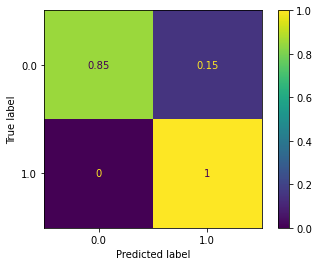

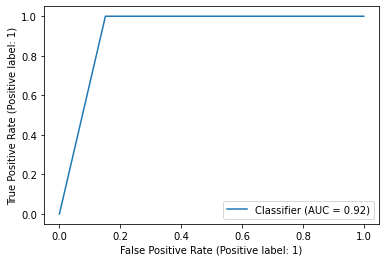

In [44]:
best_params = ["xVel", "yVel", "xA", "yA", "xC", "yC"]

svc = SVC()
std_scaler = StandardScaler()
std_scaler.fit(X_train[best_params])
svc.fit(std_scaler.transform(X_train[best_params]), y_train)
show_reports(y_test, svc.predict(std_scaler.transform(X_test[best_params])))

Estos modelos siguen tomando a la velocidad como un atributo importante
a tomar en cuenta en la clasificación.

In [45]:
score = accuracy_score(y_test, svc.predict(std_scaler.transform(X_test[best_params])))
print(f"Whitout shuffling : {score}")
for attrib in ["Vel", "A", "C"]:
    new_X = shuffle_attribs(X_test[best_params], attrib)
    score = accuracy_score(y_test, svc.predict(std_scaler.transform(new_X[best_params])))
    print(f"{attrib} : {score}")

Whitout shuffling : 0.924850221411826
Vel : 0.5295649908830424
A : 0.8650690283928106
C : 0.8521750455847877


In [46]:
dt_grid_search = GridSearchCV(dt_gs, dt_param_grid, scoring="accuracy", cv=5, return_train_score=True)
dt_grid_search.fit(X_train[best_params], y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1231),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 4, 8, 16, 32]},
                         {'max_depth': [2, 4, 8, 16, 32],
                          'max_features': [1.0, 'sqrt', 'log2']},
                         {'max_leaf_nodes': [2, 4, 8, 16, 32, 64],
                          'min_samples_split': [2, 20, 40, 60, 100]},
                         {'criterion': ['gini', 'entropy'],
                          'max_leaf_nodes': [2, 4, 8, 16, 32, 64],
                          'min_samples_split': [2, 20, 40, 60, 100]}],
             return_train_score=True, scoring='accuracy')

In [47]:
dt_results = dt_grid_search.cv_results_
sorted_dt_results = sorted(zip(dt_results["mean_test_score"], dt_results["params"]), key=lambda x: x[0], reverse=True)
for score, param in sorted_dt_results[:10]:
    print(score, param)

0.9271447355734317 {'criterion': 'entropy', 'max_leaf_nodes': 16, 'min_samples_split': 2}
0.9269275803278838 {'max_leaf_nodes': 8, 'min_samples_split': 2}
0.9269275803278838 {'max_leaf_nodes': 8, 'min_samples_split': 20}
0.9269275803278838 {'max_leaf_nodes': 8, 'min_samples_split': 40}
0.9269275803278838 {'max_leaf_nodes': 8, 'min_samples_split': 60}
0.9269275803278838 {'max_leaf_nodes': 8, 'min_samples_split': 100}
0.9269275803278838 {'criterion': 'gini', 'max_leaf_nodes': 8, 'min_samples_split': 2}
0.9269275803278838 {'criterion': 'gini', 'max_leaf_nodes': 8, 'min_samples_split': 20}
0.9269275803278838 {'criterion': 'gini', 'max_leaf_nodes': 8, 'min_samples_split': 40}
0.9269275803278838 {'criterion': 'gini', 'max_leaf_nodes': 8, 'min_samples_split': 60}


              precision    recall  f1-score   support

    Disperse       1.00      0.85      0.92      3818
    Groupped       0.87      1.00      0.93      3860

    accuracy                           0.92      7678
   macro avg       0.93      0.92      0.92      7678
weighted avg       0.93      0.92      0.92      7678



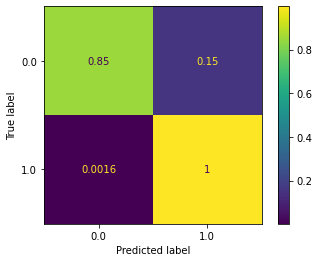

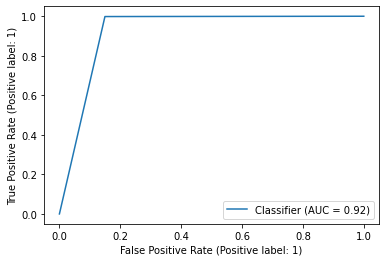

In [48]:
best_dt = dt_grid_search.best_estimator_
show_reports(y_test, best_dt.predict(X_test[best_params]))

              precision    recall  f1-score   support

    Disperse       0.92      0.90      0.91      3818
    Groupped       0.90      0.92      0.91      3860

    accuracy                           0.91      7678
   macro avg       0.91      0.91      0.91      7678
weighted avg       0.91      0.91      0.91      7678



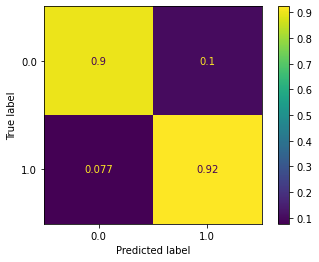

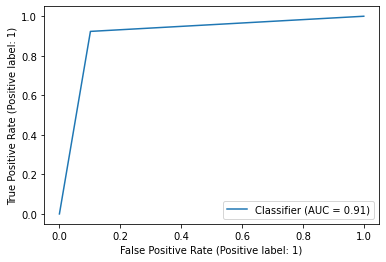

In [49]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train[best_params], y_train)
show_reports(y_test, dt.predict(X_test[best_params]))

In [50]:
feature_importances = dt.feature_importances_
attribs = X_train[best_params].columns
features_ordered = sorted(zip(feature_importances, attribs), reverse=True)
features_ordered

[(0.7097780454953733, 'xVel'),
 (0.1355517939607942, 'yC'),
 (0.057569496014782916, 'yVel'),
 (0.05607784092963886, 'yA'),
 (0.024517346170647217, 'xC'),
 (0.01650547742876356, 'xA')]

En el caso de remover la velocidad de los atributos se sigue obteniendo una buena clasificación.

              precision    recall  f1-score   support

    Disperse       0.92      0.90      0.91      3818
    Groupped       0.90      0.92      0.91      3860

    accuracy                           0.91      7678
   macro avg       0.91      0.91      0.91      7678
weighted avg       0.91      0.91      0.91      7678



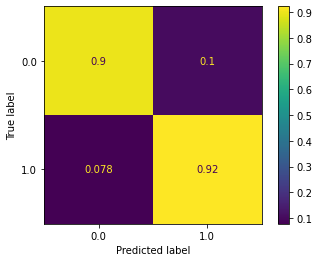

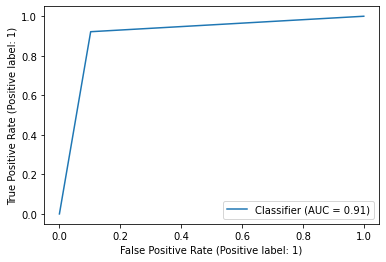

In [51]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train[best_params].drop(["xVel", "yVel"], axis=1), y_train)
show_reports(y_test, dt.predict(X_test[best_params].drop(["xVel", "yVel"], axis=1)))

## Conclusiones

Podemos decir que aunque se entrenaron al principio los modelos con todos los datos, estos ignoraban a
los que no importaban y lograban predecir muy bien usando solo los que consideraban importantes.
Tal y como vimos al inicio, si los datos se etiquetan usando la velocidad de los individuos, entonces los
modelos resultantes logran capturar esa importancia durante el entrenamiento. Aunque no dejan de lado
a los demás atributos, de hecho si se entrena un modelo usando datos donde no est ́e presente el vector
velocidad, podemos obtener un modelo considerablemente bueno. Finalmente mencionar que el tuneo de los 
hiperparámetros no logró aumentar el accuracy de los modelos, con lo cuál no es necesario hacerlo en 
este caso.